In [1]:
import numpy as np
import os

data_path = '/home/yigit/Documents/projects/irl_sfm/data/demonstrations/sfm/small_env_changing_s_g/headless/new/'
out_path = '/home/yigit/phd/yigit_phd_thesis/cnmp/data/sfm/continuous_poses_0/'

try:
    os.mkdir(f'{out_path}demonstrations')
    os.mkdir(f'{out_path}novel')
except:
  pass

demonstrations = []
novel_demonstrations = []

for filename in os.listdir(data_path):
    if filename.endswith(".npy"):
        path = os.path.join(data_path, filename)
        demonstrations.append(np.load(path, allow_pickle=True, encoding='latin1'))
#         print(f'{len(demonstrations)-1}: {path}')

novel_data_path = os.path.join(data_path, 'novel/')
for filename in os.listdir(novel_data_path):
    if filename.endswith(".npy"):
        path = os.path.join(novel_data_path, filename)
        novel_demonstrations.append(np.load(path, allow_pickle=True, encoding='latin1'))

num_demos = len(demonstrations)
num_novel = len(novel_demonstrations)

In [14]:
from tqdm import tqdm

desired_len = 400 # min_len
x_dim, gamma_dim, y_dim = 2, 2, 2

ldx, ldy, ldg = [], [], []


n_X = np.zeros((num_novel, desired_len, x_dim))
n_Gamma =  np.zeros((num_novel, desired_len, gamma_dim))
n_Y = np.zeros((num_novel, desired_len, y_dim))

print("Processing: ", end='')
for i, demo in enumerate(tqdm(demonstrations)):
    max_v_y = np.max(demo[:, x_dim+gamma_dim:x_dim+gamma_dim+y_dim])
    min_v_y = np.min(demo[:, x_dim+gamma_dim:x_dim+gamma_dim+y_dim])
    if max_v_y > 2.5 or min_v_y < -1.8:
        continue
    len_demo = len(demo)
#     print(len_demo)
    indices = np.linspace(5, len_demo-2, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    x, gmm, y = np.zeros((desired_len, x_dim)), np.zeros((desired_len, gamma_dim)), np.zeros((desired_len, y_dim))
    for new_ind, old_ind in enumerate(indices):
        x[new_ind] = demo[old_ind][:x_dim]
        gmm[new_ind] = demo[old_ind][x_dim:x_dim+gamma_dim]
        y[new_ind] = demo[old_ind][x_dim+gamma_dim:x_dim+gamma_dim+y_dim]
    
    ldx.append(x)
    ldy.append(y)
    ldg.append(gmm)
    
print("Copying: ", end='')
num_demos = len(ldx)

d_X = np.zeros((num_demos, desired_len, x_dim))
d_Gamma =  np.zeros((num_demos, desired_len, gamma_dim))
d_Y = np.zeros((num_demos, desired_len, y_dim))

for i in tqdm(range(num_demos)):
    d_X[i] = ldx[i]
    d_Gamma[i] = ldg[i]
    d_Y[i] = ldy[i]

#############
# novel case
#############

for i, demo in enumerate(novel_demonstrations):
    len_demo = len(demo)
    indices = np.linspace(0, len_demo-1, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    x, gmm, y = np.zeros((desired_len, x_dim)), np.zeros((desired_len, gamma_dim)), np.zeros((desired_len, y_dim))
    for new_ind, old_ind in enumerate(indices):
        x[new_ind] = demo[old_ind][:x_dim]
        gmm[new_ind] = demo[old_ind][x_dim:x_dim+gamma_dim]
        y[new_ind] = demo[old_ind][x_dim+gamma_dim:x_dim+gamma_dim+y_dim]
    n_X[i] = x
    n_Gamma[i] = gmm
    n_Y[i] = y

  1%|          | 82/7947 [00:00<00:09, 816.22it/s]

Processing: 

100%|██████████| 7212/7212 [00:00<00:00, 113143.75it/s]


Copying: 

[Text(0, 0.5, 'speed'), Text(0.5, 0, 'step')]

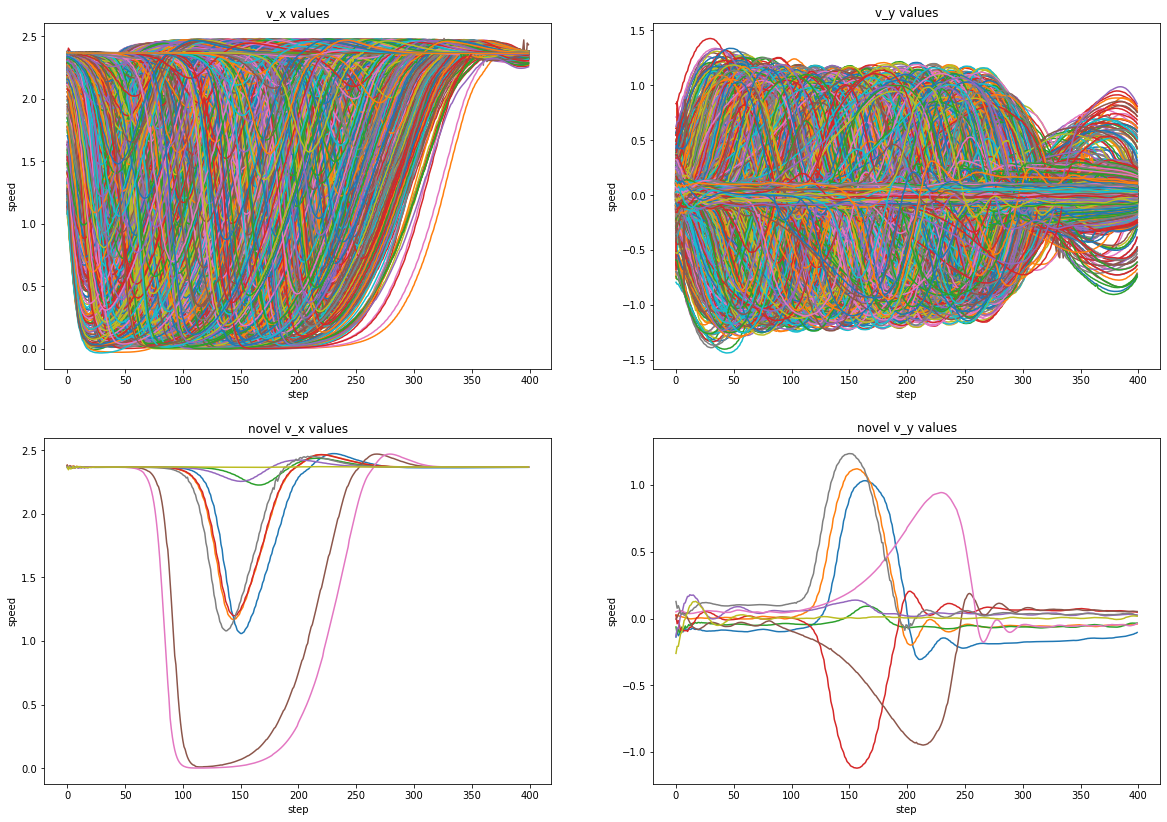

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 14]

fig, axs = plt.subplots(2, 2)
for i in range(num_demos):
    axs[0, 0].plot(range(len(d_Y[i])), d_Y[i][:, 0])  # v_x
axs[0, 0].set_title('v_x values')
axs[0, 0].set(xlabel='step', ylabel='speed')

for i in range(num_demos):
    axs[0, 1].plot(range(len(d_Y[i])), d_Y[i][:, 1])  # v_y
axs[0, 1].set_title('v_y values')
axs[0, 1].set(xlabel='step', ylabel='speed')

for i in range(num_novel):
    axs[1, 0].plot(range(len(n_Y[i])), n_Y[i][:, 0])  # v_x
axs[1, 0].set_title('novel v_x values')
axs[1, 0].set(xlabel='step', ylabel='speed')

for i in range(num_novel):
    axs[1, 1].plot(range(len(n_Y[i])), n_Y[i][:, 1])  # v_y
axs[1, 1].set_title('novel v_y values')
axs[1, 1].set(xlabel='step', ylabel='speed')

In [16]:
print(len(d_Y))

7212


In [17]:
num_val = int(num_demos/50)  # around 150 

x_train, x_val, y_train, y_val, gamma_train, gamma_val = [], [], [], [], [], []
val_indices = np.sort(np.random.choice(range(num_demos-1), num_val, replace=False))

for i in range(num_demos):
    if i in val_indices:  # validation instance
        print(f'val: {i}')
        x_val.append(d_X[i])
        gamma_val.append(d_Gamma[i])
        y_val.append(d_Y[i])
    else:  # training instance
        x_train.append(d_X[i])
        gamma_train.append(d_Gamma[i])
        y_train.append(d_Y[i])
        
np.save(out_path + 'demonstrations/' + 'd_x.npy', np.array(x_train))
np.save(out_path + 'demonstrations/' + 'd_y.npy', np.array(y_train))
np.save(out_path + 'demonstrations/' + 'd_gamma.npy', np.array(gamma_train))
np.save(out_path + 'demonstrations/' + 'v_d_x.npy', np.array(x_val))
np.save(out_path + 'demonstrations/' + 'v_d_y.npy', np.array(y_val))
np.save(out_path + 'demonstrations/' + 'v_d_gamma.npy', np.array(gamma_val))

#############
# novel case
#############

np.save(out_path + 'novel/' + 'd_x.npy', np.array(n_X))
np.save(out_path + 'novel/' + 'd_y.npy', np.array(n_Y))
np.save(out_path + 'novel/' + 'd_gamma.npy', np.array(n_Gamma))

val: 27
val: 32
val: 40
val: 82
val: 173
val: 180
val: 496
val: 506
val: 543
val: 640
val: 761
val: 831
val: 935
val: 941
val: 944
val: 996
val: 1005
val: 1013
val: 1101
val: 1223
val: 1225
val: 1231
val: 1266
val: 1315
val: 1462
val: 1495
val: 1553
val: 1584
val: 1611
val: 1634
val: 1660
val: 1685
val: 1686
val: 1706
val: 1724
val: 1753
val: 1757
val: 1849
val: 1881
val: 1898
val: 2036
val: 2046
val: 2057
val: 2071
val: 2073
val: 2175
val: 2278
val: 2286
val: 2322
val: 2373
val: 2441
val: 2571
val: 2600
val: 2665
val: 2704
val: 2830
val: 2933
val: 2989
val: 3005
val: 3036
val: 3076
val: 3091
val: 3093
val: 3152
val: 3220
val: 3245
val: 3258
val: 3266
val: 3267
val: 3297
val: 3306
val: 3351
val: 3354
val: 3429
val: 3433
val: 3476
val: 3523
val: 3604
val: 3624
val: 3650
val: 3653
val: 3730
val: 3773
val: 3808
val: 3809
val: 3845
val: 3925
val: 3967
val: 4055
val: 4132
val: 4158
val: 4176
val: 4216
val: 4226
val: 4292
val: 4419
val: 4424
val: 4548
val: 4583
val: 4593
val: 4611
val: 4648
